In [1]:
import torch  
from torch_fp.fp_opt import find_fps, fp_mse
%pylab
%load_ext autoreload
%autoreload 2

torch.Tensor.ndim = property(lambda x: len(x.shape)) #for plotting

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# GRU and task hyperparameters
u = 1         # Number of inputs to the GRU
n = 100       # Number of units in the GRU
o = 1         # Number of outputs in the GRU

# Optimization hyperparameters
num_batchs = 10000        # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.04          # initial learning rate
decay_factor = 0.9999     # decay the learning rate this much
# Gradient clipping is HUGELY important for training all RNN varieties
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.00002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100          # Print training informatino every so often

In [3]:
def get_noise_dataset(input_params):
    (bval, sval, T, ntimesteps) = input_params
    normal = torch.distributions.normal.Normal(0, 1)
    
    dt = torch.FloatTensor([T/ntimesteps])
    
    bsample = normal.sample([1])
    b = bval * 2. * (bsample - 0.5) 
    
    stddev = sval / torch.sqrt(dt)
    vsample = normal.sample([ntimesteps])
    
    noise = vsample * stddev
    white_noise = noise + b
    
    true_integral = torch.cumsum(white_noise, 0)
    final_target = torch.Tensor([(true_integral[-1] > 0.0)])
    
    target_t = torch.zeros(true_integral.shape[0]-1)
    targets_t = torch.cat([target_t, final_target], dim=0)
    
    return white_noise, targets_t
    
def generate_batch(batch_size, input_params):
    
    noises, targets = [], []
    
    for i in range(batch_size):
        n, t = get_noise_dataset(input_params)
        noises.append(n)
        targets.append(t)
        
    return torch.stack(noises).transpose(1, 0)[:, :, None].cuda(), torch.stack(targets).transpose(1, 0)[:, :, None].cuda()
    
    
    

In [4]:
noise, target = get_noise_dataset(input_params)

tensor([0.2068, 0.3485, 0.5069, 0.6284, 0.6474, 0.6077, 0.6485, 0.4795, 0.6497,
        0.6039, 0.6184, 0.6916, 0.6555, 0.5857, 0.7820, 0.9346, 0.9418, 0.9842,
        0.8938, 1.0502, 1.1942, 1.2754, 1.4558, 1.6022, 1.4196])


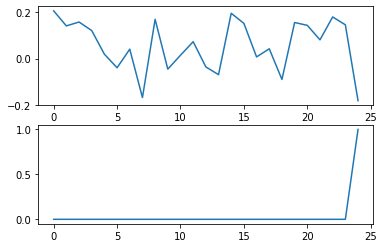

In [5]:
%matplotlib inline
ax = plt.subplot(211)
ax.plot(noise.numpy())
ax = plt.subplot(212)
ax.plot(target.numpy())

print(np.cumsum(noise))

# GRU

In [6]:
class SimpleGRU(torch.nn.Module):
    """
    Just a GRU class, (Kyunghyun Cho et al., 2014). for didactic purposes.
    I suggest you use the standard pytorch GRU class outside of this notebook
    """
    
    def __init__(self, u, n, o, use_cuda=True):
        super(SimpleGRU, self).__init__()
        self.gru = torch.nn.GRUCell(u, n)
        self.readout = torch.nn.Linear(n, o)
        self.init_s = torch.nn.Parameter(torch.randn(1,n))
        
        
    def forward(self, x):
        
        hs = []
        
        batch_size = x.shape[1]
        h = self.init_s.repeat((batch_size, 1))
        for x_t in x:
            h = self.gru(x_t, h)
            hs.append(h)
        out = self.readout(h)
        
        return out, torch.stack(hs)


In [7]:
gru = SimpleGRU(u, n, o).cuda()

In [8]:
adam = torch.optim.Adam(gru.parameters(), 
                        step_size, 
                        (adam_b1, adam_b2), 
                        adam_eps,
                       l2reg)
optim = torch.optim.lr_scheduler.ExponentialLR(adam, decay_factor)

In [9]:
noise, targets = generate_batch(batch_size, input_params)

In [10]:
mse = torch.nn.MSELoss().cuda()
def loss(pred, targets):
    targets = targets[-1, :, :]
    return mse(pred, targets)
    

In [11]:
loss(gru(noise)[0], targets)

tensor(0.4003, device='cuda:0', grad_fn=<MseLossBackward>)

In [12]:
losses = []
batch_idx = []
for i_batch in range(num_batchs):
    optim.optimizer.zero_grad()
    
    noise, targets = generate_batch(batch_size, input_params)
    
    pred, hs  = gru(noise)
    train_loss = loss(pred, targets)
    
    losses.append(train_loss.item())
    batch_idx.append(i_batch)
    
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(gru.parameters(),max_grad_norm)
    optim.step()
    optim.optimizer.step()
    
    
    if i_batch % print_every == 0:
        print("Batch", i_batch, 
                "LR:" , optim.optimizer.param_groups[0]['lr'], 
              "Training loss:", train_loss.item())

        
    


/home/lucas/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Batch 0 LR: 0.039996000000000004 Training loss: 0.4224902391433716
Batch 100 LR: 0.03959801335030015 Training loss: 0.2220699042081833
Batch 200 LR: 0.03920398693095678 Training loss: 0.18642091751098633
Batch 300 LR: 0.03881388133505894 Training loss: 0.11197035759687424
Batch 400 LR: 0.038427657547820473 Training loss: 0.08496631681919098
Batch 500 LR: 0.03804527694267816 Training loss: 0.05899146944284439
Batch 600 LR: 0.037666701277428626 Training loss: 0.06695716083049774
Batch 700 LR: 0.03729189269040369 Training loss: 0.05073050409555435
Batch 800 LR: 0.036920813696683756 Training loss: 0.044474370777606964
Batch 900 LR: 0.0365534271843491 Training loss: 0.05784585326910019
Batch 1000 LR: 0.036189696410768024 Training loss: 0.03818302974104881
Batch 1100 LR: 0.03582958499892238 Training loss: 0.02761637605726719
Batch 1200 LR: 0.03547305693376938 Training loss: 0.04730921611189842
Batch 1300 LR: 0.03512007655863975 Training loss: 0.046581052243709564
Batch 1400 LR: 0.03477060857

Text(0, 0.5, 'Training loss')

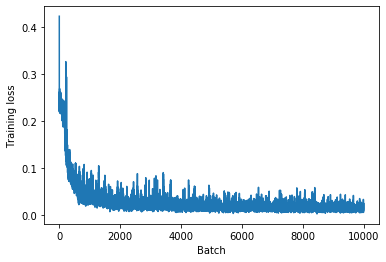

In [13]:
plt.plot(batch_idx, losses)
plt.xlabel('Batch')
plt.ylabel('Training loss')

In [14]:
noise, targets = generate_batch(eval_batch_size, input_params)
pred, hiddens  = gru(noise)
print("Loss on a new large batch: {}".format(loss(pred, targets).item())) 

Loss on a new large batch: 0.014241140335798264


## Fixed points

In [15]:
# Fixed point optimization hyperparameters
fp_num_batches = 30000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [25]:
noise, targets = generate_batch(400, input_params)
_, hiddens = gru(noise)
hiddens.shape

torch.Size([25, 400, 100])

In [26]:
p_tols = [0.0001, 0.00001, 0.000001] # Used for both fp_tol and opt_stop_tol
fp_dict = {}
for tol in p_tols:
    opt_params = {
    'num_batches' : fp_num_batches, 
    'batch_size' : fp_batch_size,
      'step_size' : fp_step_size, 
      'decay_factor' : fp_decay_factor, 
      'decay_steps' : fp_decay_steps, 
      'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
      'noise_var' : fp_noise_var, 
      'fp_opt_stop_tol' : tol, 
      'fp_tol' : tol, 
      'unique_tol' : fp_unique_tol, 
      'outlier_tol' : fp_outlier_tol, 
      'opt_print_every' : fp_opt_print_every
    }


    candidates = hiddens.view(-1, 100)
    fp_dict[tol] = find_fps(gru.gru, torch.nn.Parameter(candidates), opt_params, device='cuda')    
    
        

Optimising to find fixed points
Batches 0-128 in 0.00, Training loss 0.0439
Batches 5376-5504 in 0.00, Training loss 0.0010
Batches 640-768 in 0.00, Training loss 0.0043
Batches 6016-6144 in 0.00, Training loss 0.0032
Batches 1280-1408 in 0.00, Training loss 0.0021
Batches 6656-6784 in 0.00, Training loss 0.0023
Batches 1920-2048 in 0.00, Training loss 0.0015
Batches 7296-7424 in 0.00, Training loss 0.0017
Batches 2560-2688 in 0.00, Training loss 0.0018
Batches 7936-8064 in 0.00, Training loss 0.0012
Batches 3200-3328 in 0.00, Training loss 0.0015
Batches 8576-8704 in 0.00, Training loss 0.0024
Batches 3840-3968 in 0.00, Training loss 0.0019
Batches 9216-9344 in 0.00, Training loss 0.0019
Batches 4480-4608 in 0.00, Training loss 0.0019
Batches 9856-9984 in 0.00, Training loss 0.0018
Batches 5120-5248 in 0.00, Training loss 0.0015
Batches 384-512 in 0.00, Training loss 0.0012
Batches 5760-5888 in 0.00, Training loss 0.0020
Batches 1024-1152 in 0.00, Training loss 0.0015
Batches 6400-652

<Figure size 864x432 with 0 Axes>

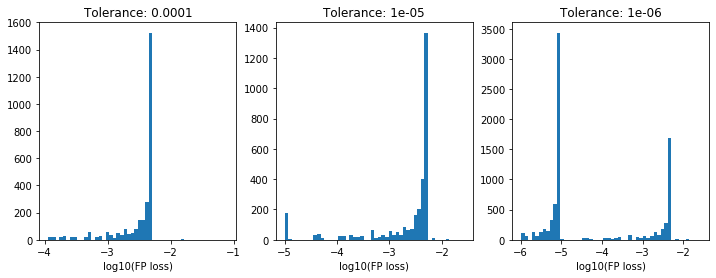

In [27]:
f1 = plt.figure(figsize=(12,6))

#for tol in p_tols: 
#    plt.semilogy(fp_dict[tol][2].cpu()); 
#    plt.xlabel('Fixed point #')
#    plt.ylabel('Fixed point loss');
#plt.legend(p_tols)
#plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(p_tols)
for tol_idx, tol in enumerate(p_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(np.log10(fp_dict[tol][2].cpu()), 50)
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol))

In [ ]:
fp_dict[tol][1].shape

In [ ]:
readouts = gru.readout(best_fps).cpu().detach().numpy()

In [ ]:
readouts[sorted_idxs].shape

In [393]:
sorted_idxs = np.argsort(readouts, axis=0).squeeze()
sorted_fps = best_fps[sorted_idxs].cpu().detach().numpy()

In [394]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [395]:
pca = PCA(3).fit(sorted_fps)
pc_fps = pca.transform(sorted_fps)


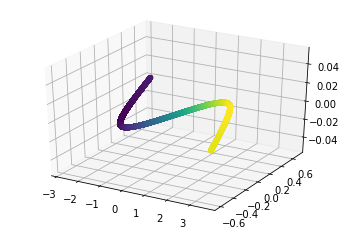

In [400]:
ax = plt.subplot(111, projection='3d')
ax.scatter(pc_fps.T[0], pc_fps.T[1], c=readouts[sorted_idxs].squeeze())
